In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

# Compute the standard error in two ways: (1) statsmodels OLS, (2) simulation

### True effect, Var(X), Var(Resid), sample size

0.031710247539790355 std of coefficients
0.03157239029501146 mean bse


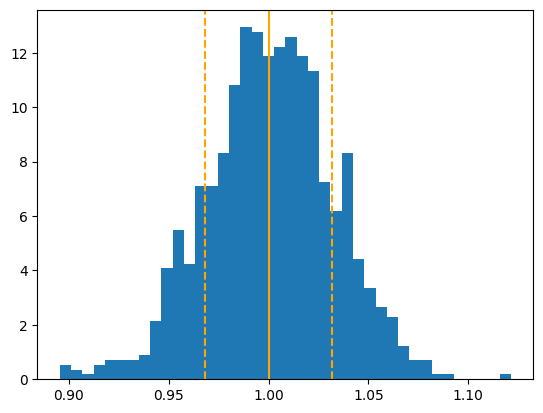

In [56]:
def compute_standard_error(true_effect, var_x, var_resid, sample_size, n_sims = 1000, random_seed = 0):
    np.random.seed(random_seed)

    params_list = list()
    bse_list = list()
    for _ in range(n_sims):
        X = np.random.normal(0, np.sqrt(var_x), sample_size)
        Y = 1 + true_effect * X + np.random.normal(0, np.sqrt(var_resid), sample_size)
        df = sm.add_constant(pd.DataFrame({"X": X})) 
        results = sm.OLS(Y, df).fit()
        params_list.append(results.params.X)
        bse_list.append(results.bse.X)
    print(np.std(params_list), "std of coefficients")
    print(np.mean(bse_list), "mean bse")

    plt.hist(params_list, density = True, bins = 40)
    plt.axvline(true_effect, color = 'orange')
    plt.axvline(true_effect + np.std(params_list), color = 'orange', label = '+1 SE', linestyle = '--')
    plt.axvline(true_effect - np.std(params_list), color = 'orange', label = '-1 SE', linestyle = '--')

compute_standard_error(1, 1, 1, 1000, n_sims = 1000, random_seed = 1)

OLS standard error 0.10305046686003075
Simulated standard error 0.10258676192023079
Mean effect 1.9979056910767667


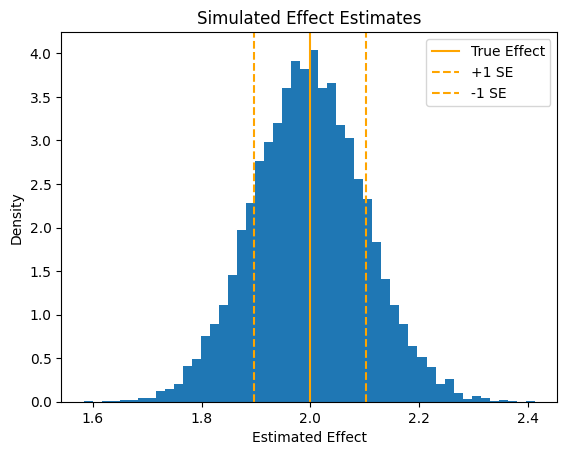

In [23]:
def compute_standard_error(true_effect, sigma_x, sigma_resid, num, n_sim=10000, random_seed=0):
    np.random.seed(random_seed)
    
    # OLS standard error
    X = np.random.normal(0, sigma_x, size=num)
    Y = true_effect * X + np.random.normal(0, sigma_resid, num)
    df = sm.add_constant(pd.DataFrame({"X": X}))
    model = sm.OLS(Y, df).fit()
    ols_se = model.bse.X

    # Simulation-based standard error
    effects = []
    for _ in range(n_sim):
        X_sim = np.random.normal(0, sigma_x, size=num)
        Y_sim = true_effect * X_sim + np.random.normal(0, sigma_resid, num)
        df = sm.add_constant(pd.DataFrame({"X": X_sim}))
        model_sim = sm.OLS(Y_sim, df).fit()
        effects.append(model_sim.params.X)
    sim_se = np.std(effects)

    plt.hist(effects, bins=50, density=True)
    plt.axvline(true_effect, color='orange', linestyle='-', label='True Effect')
    plt.axvline(true_effect + sim_se, color='orange', linestyle='--', label='+1 SE')
    plt.axvline(true_effect - sim_se, color='orange', linestyle='--', label='-1 SE')
    plt.title('Simulated Effect Estimates')
    plt.xlabel('Estimated Effect')
    plt.ylabel('Density')
    plt.legend()

    print("OLS standard error", ols_se)
    print("Simulated standard error", sim_se)
    print("Mean effect", np.mean(effects))

compute_standard_error(true_effect=2.0, sigma_x=1.0, sigma_resid=1.0, num=100, n_sim=10000)

# Compute statistical power

In [54]:
(np.random.normal(1.96 + 1.645, 1, 100000) > 1.96).mean()

0.94967

In [59]:
def compute_power(true_effect, sigma_x, sigma_resid, num, n_sim=10000, random_seed=0):
    np.random.seed(random_seed)
    critical_t = 1.96

    detections = 0

    for _ in range(n_sim):
        X = np.random.normal(0, sigma_x, size=num)
        Y = 1 + true_effect * X + np.random.normal(0, sigma_resid, size=num)
        df = sm.add_constant(pd.DataFrame({"X": X}))
        results = sm.OLS(Y, df).fit()
        t_value = results.tvalues.X
        if np.abs(t_value) > critical_t:
            detections += 1

    power = detections / n_sim
    return power

power = compute_power(true_effect = (1.96 + 1.645) * np.sqrt(1/1000), sigma_x=1.0, sigma_resid=1.0, num=1000, n_sim=1000)

print(f"Estimated Statistical Power: {power:.4f}")

Estimated Statistical Power: 0.9460


# Sample size for power

In [65]:
np.exp(np.linspace(0, np.log(10), 10))

array([ 1.        ,  1.29154967,  1.66810054,  2.15443469,  2.7825594 ,
        3.59381366,  4.64158883,  5.9948425 ,  7.74263683, 10.        ])

In [66]:
def sample_size_for_power(min_sample_size, max_sample_size, num_sizes):
    sizes = min_sample_size * np.exp(np.linspace(0, np.log(max_sample_size / min_sample_size), num = num_sizes))
    sizes = [int(np.around(x)) for x in sizes]
    power_list = list()
    for size in sizes:
        power = compute_power(0.5, 1, 1, size, 1000, 0)
        power_list.append(power)
    print(sizes)
    return power_list

sample_size_for_power(10, 1000, 10)

[10, 17, 28, 46, 77, 129, 215, 359, 599, 1000]


[0.341, 0.535, 0.714, 0.895, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0]

# Binary search for sample size for power

In [51]:
def binary_search_for_sample_size(min_sample_size, max_sample_size, goal_power):
    average_sample_size = int((min_sample_size + max_sample_size) / 2)
    computed_power = compute_power(0.5, 1, 1, average_sample_size, 1000, 0)
    # print(min_sample_size, max_sample_size, computed_power)
    if min_sample_size == max_sample_size:
        return computed_power, average_sample_size
    if computed_power >= goal_power:
        return binary_search_for_sample_size(min_sample_size, average_sample_size, goal_power)
    if computed_power < goal_power:
        return binary_search_for_sample_size(average_sample_size + 1, max_sample_size, goal_power)

binary_search_for_sample_size(10, 1000, 0.8)

(0.804, 34)

# Find sample size for power

In [77]:
def compute_power(true_effect, sigma_x, sigma_eps, num, n_sim=100, random_seed=42):
    np.random.seed(random_seed)
    critical_t = 1.96
    detections = 0

    for _ in range(n_sim):
        X = np.random.normal(0, sigma_x, size=num)
        Y = true_effect * X + np.random.normal(0, sigma_eps, size=num)
        df = sm.add_constant(pd.DataFrame({"X": X}))
        results = sm.OLS(Y, df).fit()
        t_value = results.tvalues.X
        if abs(t_value) > critical_t:
            detections += 1

    return detections / n_sim

def binary_search_for_power(min_size = 10, max_size = 1000, power_goal = 0.8):
    average_size = int((min_size + max_size) / 2)    
    power = compute_power(1, 1, 1, average_size, n_sim=100, random_seed = 0)
    if min_size == max_size:
        return power, average_size
    if power > power_goal:
        return binary_search_for_power(min_size, average_size, power_goal)
    elif power < power_goal:
        return binary_search_for_power(average_size + 1, max_size, power_goal)
    else: # power == power_goal
        return power, average_size

binary_search_for_power(10, 1000, 0.99)

(0.99, 28)